In [16]:
# Experiment 4: Can a neural network learn to classifiy arithmetic operations?


## Objective
The experiment aims to find out if nn can learn to classifiy arithmetic operations.

## Problem Specification
- **Input**: x, y, z
- **Output**: can be +,-,*,/
- **Task**: Implementation of a neural network that can learn to classify arithmetic operations

## Expected Outcome
- A neural network can learn to classify arithmetic operations

SyntaxError: expected 'else' after 'if' expression (1738811952.py, line 5)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ArithmeticClassifier(nn.Module):
    def __init__(self, first_layer_size, second_layer_size):
        super(ArithmeticClassifier, self).__init__()
        
        # Input layer (3 inputs: a, b, c where c = operation(a, b))
        self.input = nn.Linear(3, first_layer_size)
        
        # Triple activation for first hidden layer
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.identity = nn.Identity()
        
        # Weights for activation functions
        self.act_weights = nn.Parameter(torch.ones(3, first_layer_size) / 3)
        
        # Second hidden layer (standard with ReLU)
        self.hidden = nn.Linear(first_layer_size, second_layer_size)
        self.hidden_activation = nn.ReLU()
        
        # Output layer (4 classes: add, subtract, multiply, divide)
        self.output = nn.Linear(second_layer_size, 4)
        
    def forward(self, x):
        # First hidden layer with triple activation
        x = self.input(x)
        
        # Apply weighted activations
        activated = (self.tanh(x) * self.act_weights[0].unsqueeze(0) + 
                    self.leaky_relu(x) * self.act_weights[1].unsqueeze(0) +
                    self.identity(x) * self.act_weights[2].unsqueeze(0))
        
        # Second hidden layer
        x = self.hidden(activated)
        x = self.hidden_activation(x)
        
        # Output layer (no softmax here as it's included in CrossEntropyLoss)
        return self.output(x)

def analyze_activations(model):
    # Get weights assigned to each activation function
    with torch.no_grad():
        weights = model.act_weights.detach().cpu()
        
        # Calculate importance of each activation
        activation_names = ['Tanh', 'LeakyReLU', 'Linear']
        importance = torch.mean(torch.abs(weights), dim=1)
        
        # Normalize to percentage
        total = torch.sum(importance)
        if total > 0:
            importance = 100 * importance / total
            
            print("\nActivation Function Analysis:")
            print("-" * 40)
            for i, name in enumerate(activation_names):
                print(f"{name:>10}: {importance[i].item():>7.2f}%")
                
            print(f"\nTotal weight magnitude: {total.item():.6f}")
        else:
            print("\nActivation Function Analysis:")
            print("-" * 40)
            print("All activation weights are zero")

def generate_data(num_samples=1000):
    """Generate training data for arithmetic operations"""
    a = np.random.uniform(-10, 10, num_samples)
    b = np.random.uniform(-10, 10, num_samples)
    
    # Avoid division by zero or very small numbers
    b[np.abs(b) < 0.1] = 0.1 * np.sign(b[np.abs(b) < 0.1])
    
    # Create results for all operations
    results = np.zeros((num_samples, 4))
    results[:, 0] = a + b      # Addition
    results[:, 1] = a - b      # Subtraction
    results[:, 2] = a * b      # Multiplication
    results[:, 3] = a / b      # Division
    
    # For each sample, select one operation randomly
    selected_ops = np.random.randint(0, 4, num_samples)
    c = np.zeros(num_samples)
    
    for i in range(num_samples):
        c[i] = results[i, selected_ops[i]]
    
    # Create input features [a, b, c] and labels [operation]
    X = np.column_stack((a, b, c))
    y = selected_ops
    
    return X, y

def train_and_evaluate(first_layer_size, second_layer_size, max_epochs=500):
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Create model
    model = ArithmeticClassifier(first_layer_size, second_layer_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Generate data
    X_train, y_train = generate_data(5000)
    X_val, y_val = generate_data(1000)
    X_test, y_test = generate_data(1000)
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    best_val_accuracy = 0
    best_model_state = None
    patience = 20
    no_improve = 0
    
    train_losses = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(max_epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            _, predicted = torch.max(val_outputs, 1)
            val_accuracy = (predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
            val_accuracies.append(val_accuracy)
            
            # Print progress occasionally
            if epoch % 50 == 0:
                print(f"  Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")
            
            # Track best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = model.state_dict().copy()
                no_improve = 0
            else:
                no_improve += 1
            
            # Check if we've reached target accuracy
            if val_accuracy >= 0.99:
                print(f"✓ Target achieved with layers ({first_layer_size}, {second_layer_size}) at epoch {epoch+1}")
                print(f"  Validation Accuracy: {val_accuracy:.4f}")
                
                # Load best model
                if best_model_state:
                    model.load_state_dict(best_model_state)
                
                # Final test evaluation
                test_outputs = model(X_test_tensor)
                _, predicted = torch.max(test_outputs, 1)
                test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
                
                return {
                    'model': model,
                    'layer1': first_layer_size,
                    'layer2': second_layer_size,
                    'epochs': epoch+1,
                    'val_accuracy': val_accuracy,
                    'test_accuracy': test_accuracy,
                    'train_losses': train_losses,
                    'val_accuracies': val_accuracies,
                    'success': True
                }
            
            # Early stopping
            if no_improve >= patience:
                print(f"× Early stopping at epoch {epoch+1}")
                print(f"  Best validation accuracy: {best_val_accuracy:.4f}")
                
                # Load best model
                if best_model_state:
                    model.load_state_dict(best_model_state)
                
                # Final test evaluation
                test_outputs = model(X_test_tensor)
                _, predicted = torch.max(test_outputs, 1)
                test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
                
                return {
                    'model': model,
                    'layer1': first_layer_size,
                    'layer2': second_layer_size,
                    'epochs': epoch+1,
                    'val_accuracy': best_val_accuracy,
                    'test_accuracy': test_accuracy,
                    'train_losses': train_losses,
                    'val_accuracies': val_accuracies,
                    'success': best_val_accuracy >= 0.99
                }
    
    # Load best model before final evaluation
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Final test evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    
    print(f"× Reached max epochs ({max_epochs})")
    print(f"  Best validation accuracy: {best_val_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
    
    return {
        'model': model,
        'layer1': first_layer_size,
        'layer2': second_layer_size,
        'epochs': max_epochs,
        'val_accuracy': best_val_accuracy,
        'test_accuracy': test_accuracy,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'success': best_val_accuracy >= 0.99
    }

def test_examples(model):
    """Test model on specific examples with all four operations"""
    operations = ['Addition', 'Subtraction', 'Multiplication', 'Division']
    
    examples = [
        [2, 3, 5],      # 2 + 3 = 5
        [7, 4, 3],      # 7 - 4 = 3
        [5, 6, 30],     # 5 * 6 = 30
        [10, 2, 5],     # 10 / 2 = 5
    ]
    
    print("\nTesting Model with Examples:")
    print("-" * 60)
    print(f"{'a':^8} | {'b':^8} | {'c':^8} | {'Predicted':^15} | {'Expected':^15}")
    print("-" * 60)
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for i, example in enumerate(examples):
            a, b, c = example
            input_tensor = torch.FloatTensor([example])
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            pred_op = operations[predicted.item()]
            expected_op = operations[i]
            
            print(f"{a:^8} | {b:^8} | {c:^8} | {pred_op:^15} | {expected_op:^15}")
            
            if pred_op == expected_op:
                correct += 1
    
    print(f"\nAccuracy on examples: {correct}/{len(examples)}")

# Test different combinations of layer sizes
print("Testing different layer size combinations for arithmetic operations classifier")
print("=" * 70)

# Define combinations to test
layer_combinations = [
    (8, 8),
    (16, 8),
    (12, 12),
    (16, 16),
    (24, 12),
    (32, 16),
    (16, 32)
]

additional_combinations = [
    (32, 32),    # Balanced larger model
    (32, 64),    # Wider second layer
    (48, 32),    # Wider first layer
    (64, 32),    # Even wider first layer 
    (24, 48),    # Another asymmetric configuration
    (20, 40),    # Smaller but similar ratio to the best so far
    (40, 20)     # Reverse ratio experiment
]

layer_combinations.extend(additional_combinations)

results = []

for layer1, layer2 in layer_combinations:
    print(f"\nTesting with first layer: {layer1} neurons, second layer: {layer2} neurons")
    result = train_and_evaluate(layer1, layer2)
    
    test_examples(result['model'])
    analyze_activations(result['model'])
    
    results.append(result)
    
    # If we've found a successful model, we can stop
    if result['success'] and result['test_accuracy'] >= 0.99:
        print(f"\n✓ Found minimum configuration with layers ({layer1}, {layer2})")
        break

# Show summary of all configurations
print("\n" + "=" * 100)
print("Configuration Results (sorted by test accuracy):")
print("-" * 100)
print(f"{'Layer 1':^8} | {'Layer 2':^8} | {'Epochs':^8} | {'Val Accuracy':^15} | {'Test Accuracy':^15} | {'Success':^10}")
print("-" * 100)

# Sort by test accuracy (best first)
for r in sorted(results, key=lambda x: x['test_accuracy'], reverse=True):
    print(f"{r['layer1']:^8} | {r['layer2']:^8} | {r['epochs']:^8} | {r['val_accuracy']:.4f}{' ':^9} | {r['test_accuracy']:.4f}{' ':^9} | {'✓' if r['success'] else '×'}")

# Find the best configuration
best_config = max(results, key=lambda x: x['test_accuracy'])

print("\nBest Overall Configuration:")
print(f"- Layer 1: {best_config['layer1']} neurons")
print(f"- Layer 2: {best_config['layer2']} neurons")
print(f"- Trained for {best_config['epochs']} epochs")
print(f"- Validation Accuracy: {best_config['val_accuracy']:.4f}")
print(f"- Test Accuracy: {best_config['test_accuracy']:.4f}")
print(f"- Success: {'Yes' if best_config['success'] else 'No'}")

# Final activation analysis
print("\nFinal activation analysis for the best model:")
analyze_activations(best_config['model'])

Testing different layer size combinations for arithmetic operations classifier

Testing with first layer: 8 neurons, second layer: 8 neurons
  Epoch 0: Train Loss: 1.6969, Val Accuracy: 0.2130
  Epoch 50: Train Loss: 1.3582, Val Accuracy: 0.3100
  Epoch 100: Train Loss: 1.2877, Val Accuracy: 0.3940
  Epoch 150: Train Loss: 1.1695, Val Accuracy: 0.4700
× Early stopping at epoch 151
  Best validation accuracy: 0.4880

Testing Model with Examples:
------------------------------------------------------------
   a     |    b     |    c     |    Predicted    |    Expected    
------------------------------------------------------------
   2     |    3     |    5     |    Division     |    Addition    
   7     |    4     |    3     |    Addition     |   Subtraction  
   5     |    6     |    30    | Multiplication  | Multiplication 
   10    |    2     |    5     |    Addition     |    Division    

Accuracy on examples: 1/4

Activation Function Analysis:
------------------------------------

Training the best configuration for visualization
  Epoch 0: Train Loss: 1.4374, Val Accuracy: 0.2720
  Epoch 50: Train Loss: 0.8009, Val Accuracy: 0.7520
  Epoch 100: Train Loss: 0.4971, Val Accuracy: 0.8490
  Epoch 150: Train Loss: 0.3570, Val Accuracy: 0.8740
  Epoch 200: Train Loss: 0.2666, Val Accuracy: 0.8930
  Epoch 250: Train Loss: 0.2099, Val Accuracy: 0.9180
  Epoch 300: Train Loss: 0.1729, Val Accuracy: 0.9420
  Epoch 350: Train Loss: 0.1477, Val Accuracy: 0.9520
  Epoch 400: Train Loss: 0.1287, Val Accuracy: 0.9550
  Epoch 450: Train Loss: 0.1130, Val Accuracy: 0.9580
  Epoch 500: Train Loss: 0.0997, Val Accuracy: 0.9610
  Epoch 550: Train Loss: 0.0893, Val Accuracy: 0.9680
  Epoch 600: Train Loss: 0.0810, Val Accuracy: 0.9690
  Epoch 650: Train Loss: 0.0740, Val Accuracy: 0.9730
  Epoch 700: Train Loss: 0.0674, Val Accuracy: 0.9730
  Epoch 750: Train Loss: 0.0614, Val Accuracy: 0.9760
  Epoch 800: Train Loss: 0.0561, Val Accuracy: 0.9760
× Early stopping at epoch 808
  Bes

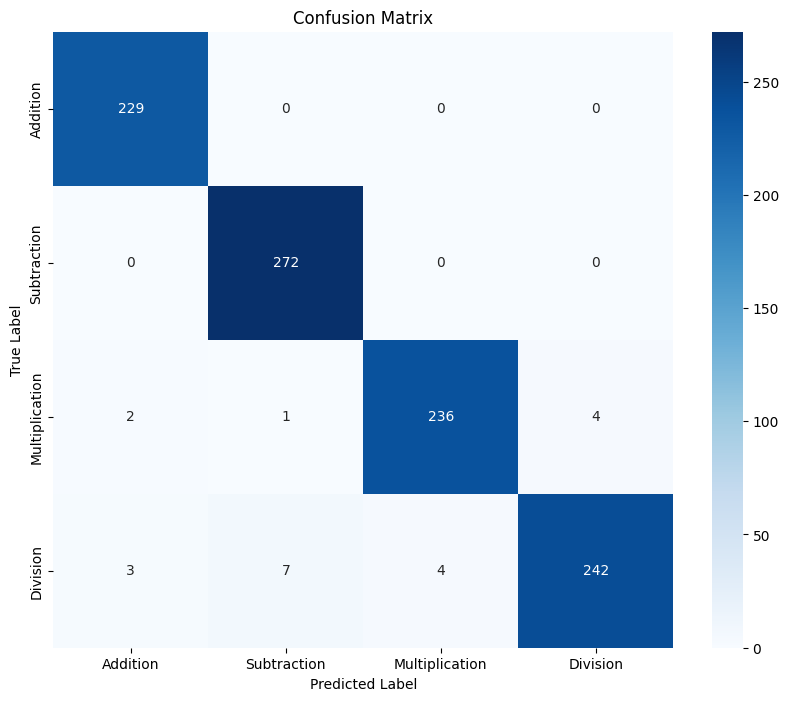


Configuration Results:
------------------------------------------------------------------------------------------------------------------------
Layer 1  | Layer 2  | Layer 3  |  Epochs  |  Val Accuracy   |  Test Accuracy  |  Success  
------------------------------------------------------------------------------------------------------------------------
  128    |    64    |    32    |   808    | 0.9790          | 0.9790          | ×

Best Configuration:
- Layer 1: 128 neurons
- Layer 2: 64 neurons
- Layer 3: 32 neurons
- Trained for 808 epochs
- Validation Accuracy: 0.9790
- Test Accuracy: 0.9790
- Success: No

Activation function analysis:

Activation Function Analysis:
----------------------------------------
      Tanh:   34.73%
 LeakyReLU:   32.28%
    Linear:   32.99%

Total weight magnitude: 1.518473


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class ArithmeticClassifier(nn.Module):
   def __init__(self, first_layer_size, second_layer_size, third_layer_size):
       super(ArithmeticClassifier, self).__init__()
       
       # Input layer (3 inputs: a, b, c where c = operation(a, b))
       self.input = nn.Linear(3, first_layer_size)
       
       # Triple activation for first hidden layer
       self.tanh = nn.Tanh()
       self.leaky_relu = nn.LeakyReLU(0.1)
       self.identity = nn.Identity()
       
       # Weights for activation functions
       self.act_weights = nn.Parameter(torch.ones(3, first_layer_size) / 3)
       
       # Second hidden layer
       self.hidden = nn.Linear(first_layer_size, second_layer_size)
       self.hidden_activation = nn.ReLU()
       
       # Third hidden layer
       self.hidden2 = nn.Linear(second_layer_size, third_layer_size)
       self.hidden_activation2 = nn.ReLU()
       
       # Output layer (4 classes: add, subtract, multiply, divide)
       self.output = nn.Linear(third_layer_size, 4)
       
   def forward(self, x):
       # First hidden layer with triple activation
       x = self.input(x)
       
       # Apply weighted activations
       activated = (self.tanh(x) * self.act_weights[0].unsqueeze(0) + 
                   self.leaky_relu(x) * self.act_weights[1].unsqueeze(0) +
                   self.identity(x) * self.act_weights[2].unsqueeze(0))
       
       # Second hidden layer
       x = self.hidden(activated)
       x = self.hidden_activation(x)
       
       # Third hidden layer
       x = self.hidden2(x)
       x = self.hidden_activation2(x)
       
       # Output layer
       return self.output(x)

def analyze_activations(model):
   # Get weights assigned to each activation function
   with torch.no_grad():
       weights = model.act_weights.detach().cpu()
       
       # Calculate importance of each activation
       activation_names = ['Tanh', 'LeakyReLU', 'Linear']
       importance = torch.mean(torch.abs(weights), dim=1)
       
       # Normalize to percentage
       total = torch.sum(importance)
       if total > 0:
           importance = 100 * importance / total
           
           print("\nActivation Function Analysis:")
           print("-" * 40)
           for i, name in enumerate(activation_names):
               print(f"{name:>10}: {importance[i].item():>7.2f}%")
               
           print(f"\nTotal weight magnitude: {total.item():.6f}")
       else:
           print("\nActivation Function Analysis:")
           print("-" * 40)
           print("All activation weights are zero")

def generate_data(num_samples=1000):
   """Generate training data for arithmetic operations"""
   a = np.random.uniform(-10, 10, num_samples)
   b = np.random.uniform(-10, 10, num_samples)
   
   # Increase minimum threshold for b values
   b[np.abs(b) < 0.5] = 0.5 * np.sign(b[np.abs(b) < 0.5])
   
   # Round values to reduce floating point issues
   a = np.round(a, 2)
   b = np.round(b, 2)
   
   # Create results for all operations
   results = np.zeros((num_samples, 4))
   results[:, 0] = a + b      # Addition
   results[:, 1] = a - b      # Subtraction
   results[:, 2] = a * b      # Multiplication
   results[:, 3] = a / b      # Division
   
   # For each sample, select one operation randomly
   selected_ops = np.random.randint(0, 4, num_samples)
   c = np.zeros(num_samples)
   
   for i in range(num_samples):
       c[i] = results[i, selected_ops[i]]
   
   # Create input features [a, b, c] and labels [operation]
   X = np.column_stack((a, b, c))
   y = selected_ops
   
   return X, y

def train_and_evaluate(first_layer_size, second_layer_size, third_layer_size, max_epochs=1000):
   torch.manual_seed(42)
   np.random.seed(42)
   
   # Create model
   model = ArithmeticClassifier(first_layer_size, second_layer_size, third_layer_size)
   optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
   criterion = nn.CrossEntropyLoss()
   
   # Generate data
   X_train, y_train = generate_data(5000)
   X_val, y_val = generate_data(1000)
   X_test, y_test = generate_data(1000)
   
   # Convert to tensors
   X_train_tensor = torch.FloatTensor(X_train)
   y_train_tensor = torch.LongTensor(y_train)
   X_val_tensor = torch.FloatTensor(X_val)
   y_val_tensor = torch.LongTensor(y_val)
   X_test_tensor = torch.FloatTensor(X_test)
   y_test_tensor = torch.LongTensor(y_test)
   
   best_val_accuracy = 0
   best_model_state = None
   patience = 50
   no_improve = 0
   
   train_losses = []
   val_accuracies = []
   
   # Training loop
   for epoch in range(max_epochs):
       # Train
       model.train()
       optimizer.zero_grad()
       outputs = model(X_train_tensor)
       loss = criterion(outputs, y_train_tensor)
       loss.backward()
       optimizer.step()
       
       train_losses.append(loss.item())
       
       # Evaluate
       model.eval()
       with torch.no_grad():
           val_outputs = model(X_val_tensor)
           _, predicted = torch.max(val_outputs, 1)
           val_accuracy = (predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
           val_accuracies.append(val_accuracy)
           
           # Print progress occasionally
           if epoch % 50 == 0:
               print(f"  Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")
           
           # Track best model
           if val_accuracy > best_val_accuracy:
               best_val_accuracy = val_accuracy
               best_model_state = model.state_dict().copy()
               no_improve = 0
           else:
               no_improve += 1
           
           # Check if we've reached target accuracy
           if val_accuracy >= 0.999:
               print(f"✓ Target achieved with layers ({first_layer_size}, {second_layer_size}, {third_layer_size}) at epoch {epoch+1}")
               print(f"  Validation Accuracy: {val_accuracy:.4f}")
               
               # Load best model
               if best_model_state:
                   model.load_state_dict(best_model_state)
               
               # Final test evaluation
               test_outputs = model(X_test_tensor)
               _, predicted = torch.max(test_outputs, 1)
               test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
               
               return {
                   'model': model,
                   'layer1': first_layer_size,
                   'layer2': second_layer_size,
                   'layer3': third_layer_size,
                   'epochs': epoch+1,
                   'val_accuracy': val_accuracy,
                   'test_accuracy': test_accuracy,
                   'train_losses': train_losses,
                   'val_accuracies': val_accuracies,
                   'success': True,
                   'X_test': X_test,
                   'y_test': y_test,
                   'y_pred': predicted.cpu().numpy()
               }
           
           # Early stopping
           if no_improve >= patience:
               print(f"× Early stopping at epoch {epoch+1}")
               print(f"  Best validation accuracy: {best_val_accuracy:.4f}")
               
               # Load best model
               if best_model_state:
                   model.load_state_dict(best_model_state)
               
               # Final test evaluation
               test_outputs = model(X_test_tensor)
               _, predicted = torch.max(test_outputs, 1)
               test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
               
               return {
                   'model': model,
                   'layer1': first_layer_size,
                   'layer2': second_layer_size,
                   'layer3': third_layer_size,
                   'epochs': epoch+1,
                   'val_accuracy': best_val_accuracy,
                   'test_accuracy': test_accuracy,
                   'train_losses': train_losses,
                   'val_accuracies': val_accuracies,
                   'success': best_val_accuracy >= 0.999,
                   'X_test': X_test,
                   'y_test': y_test,
                   'y_pred': predicted.cpu().numpy()
               }
   
   # Load best model before final evaluation
   if best_model_state:
       model.load_state_dict(best_model_state)
   
   # Final test evaluation
   model.eval()
   with torch.no_grad():
       test_outputs = model(X_test_tensor)
       _, predicted = torch.max(test_outputs, 1)
       test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
   
   print(f"× Reached max epochs ({max_epochs})")
   print(f"  Best validation accuracy: {best_val_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
   
   return {
       'model': model,
       'layer1': first_layer_size,
       'layer2': second_layer_size,
       'layer3': third_layer_size,
       'epochs': max_epochs,
       'val_accuracy': best_val_accuracy,
       'test_accuracy': test_accuracy,
       'train_losses': train_losses,
       'val_accuracies': val_accuracies,
       'success': best_val_accuracy >= 0.999,
       'X_test': X_test,
       'y_test': y_test,
       'y_pred': predicted.cpu().numpy()
   }

def plot_confusion_matrix(result):
   """Plot confusion matrix for the test results"""
   operations = ['Addition', 'Subtraction', 'Multiplication', 'Division']
   
   # Calculate confusion matrix
   cm = confusion_matrix(result['y_test'], result['y_pred'])
   
   # Plot
   plt.figure(figsize=(10, 8))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=operations, yticklabels=operations)
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   plt.title('Confusion Matrix')
   plt.show()

# Test the best configuration from previous run
print("Training the best configuration for visualization")
print("=" * 70)

# Best configuration
layer1 = 128
layer2 = 64 
layer3 = 32

result = train_and_evaluate(layer1, layer2, layer3)
analyze_activations(result['model'])

# Plot confusion matrix
plot_confusion_matrix(result)

# Show summary
print("\n" + "=" * 120)
print("Configuration Results:")
print("-" * 120)
print(f"{'Layer 1':^8} | {'Layer 2':^8} | {'Layer 3':^8} | {'Epochs':^8} | {'Val Accuracy':^15} | {'Test Accuracy':^15} | {'Success':^10}")
print("-" * 120)
print(f"{result['layer1']:^8} | {result['layer2']:^8} | {result['layer3']:^8} | {result['epochs']:^8} | {result['val_accuracy']:.4f}{' ':^9} | {result['test_accuracy']:.4f}{' ':^9} | {'✓' if result['success'] else '×'}")

print("\nBest Configuration:")
print(f"- Layer 1: {result['layer1']} neurons")
print(f"- Layer 2: {result['layer2']} neurons")
print(f"- Layer 3: {result['layer3']} neurons")
print(f"- Trained for {result['epochs']} epochs")
print(f"- Validation Accuracy: {result['val_accuracy']:.4f}")
print(f"- Test Accuracy: {result['test_accuracy']:.4f}")
print(f"- Success: {'Yes' if result['success'] else 'No'}")

print("\nActivation function analysis:")
analyze_activations(result['model'])

Training the best configuration for visualization
  Epoch 0: Train Loss: 1.4374, Val Accuracy: 0.2720
  Epoch 50: Train Loss: 0.8009, Val Accuracy: 0.7520
  Epoch 100: Train Loss: 0.4971, Val Accuracy: 0.8490
  Epoch 150: Train Loss: 0.3570, Val Accuracy: 0.8740
  Epoch 200: Train Loss: 0.2666, Val Accuracy: 0.8930
  Epoch 250: Train Loss: 0.2099, Val Accuracy: 0.9180
  Epoch 300: Train Loss: 0.1729, Val Accuracy: 0.9420
  Epoch 350: Train Loss: 0.1477, Val Accuracy: 0.9520
  Epoch 400: Train Loss: 0.1287, Val Accuracy: 0.9550
  Epoch 450: Train Loss: 0.1130, Val Accuracy: 0.9580
  Epoch 500: Train Loss: 0.0997, Val Accuracy: 0.9610
  Epoch 550: Train Loss: 0.0893, Val Accuracy: 0.9680
  Epoch 600: Train Loss: 0.0810, Val Accuracy: 0.9690
  Epoch 650: Train Loss: 0.0740, Val Accuracy: 0.9730
  Epoch 700: Train Loss: 0.0674, Val Accuracy: 0.9730
  Epoch 750: Train Loss: 0.0614, Val Accuracy: 0.9760
  Epoch 800: Train Loss: 0.0561, Val Accuracy: 0.9760
× Early stopping at epoch 808
  Bes

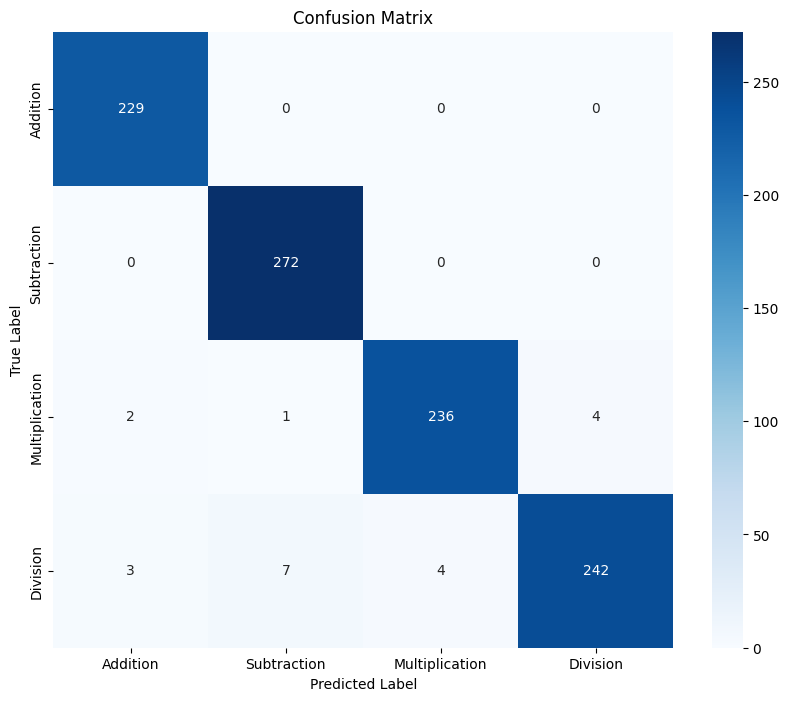


Configuration Results:
------------------------------------------------------------------------------------------------------------------------
Layer 1  | Layer 2  | Layer 3  |  Epochs  |  Val Accuracy   |  Test Accuracy  |  Success  
------------------------------------------------------------------------------------------------------------------------
  128    |    64    |    32    |   808    | 0.9790          | 0.9790          | ×

Best Configuration:
- Layer 1: 128 neurons
- Layer 2: 64 neurons
- Layer 3: 32 neurons
- Trained for 808 epochs
- Validation Accuracy: 0.9790
- Test Accuracy: 0.9790
- Success: No

Activation function analysis:

Activation Function Analysis:
----------------------------------------
      Tanh:   34.73%
 LeakyReLU:   32.28%
    Linear:   32.99%

Total weight magnitude: 1.518473


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class ArithmeticClassifier(nn.Module):
   def __init__(self, first_layer_size, second_layer_size, third_layer_size):
       super(ArithmeticClassifier, self).__init__()
       
       # Input layer (3 inputs: a, b, c where c = operation(a, b))
       self.input = nn.Linear(3, first_layer_size)
       
       # Triple activation for first hidden layer
       self.tanh = nn.Tanh()
       self.leaky_relu = nn.LeakyReLU(0.1)
       self.identity = nn.Identity()
       
       # Weights for activation functions
       self.act_weights = nn.Parameter(torch.ones(3, first_layer_size) / 3)
       
       # Second hidden layer
       self.hidden = nn.Linear(first_layer_size, second_layer_size)
       self.hidden_activation = nn.ReLU()
       
       # Third hidden layer
       self.hidden2 = nn.Linear(second_layer_size, third_layer_size)
       self.hidden_activation2 = nn.ReLU()
       
       # Output layer (4 classes: add, subtract, multiply, divide)
       self.output = nn.Linear(third_layer_size, 4)
       
   def forward(self, x):
       # First hidden layer with triple activation
       x = self.input(x)
       
       # Apply weighted activations
       activated = (self.tanh(x) * self.act_weights[0].unsqueeze(0) + 
                   self.leaky_relu(x) * self.act_weights[1].unsqueeze(0) +
                   self.identity(x) * self.act_weights[2].unsqueeze(0))
       
       # Second hidden layer
       x = self.hidden(activated)
       x = self.hidden_activation(x)
       
       # Third hidden layer
       x = self.hidden2(x)
       x = self.hidden_activation2(x)
       
       # Output layer
       return self.output(x)

def analyze_activations(model):
   # Get weights assigned to each activation function
   with torch.no_grad():
       weights = model.act_weights.detach().cpu()
       
       # Calculate importance of each activation
       activation_names = ['Tanh', 'LeakyReLU', 'Linear']
       importance = torch.mean(torch.abs(weights), dim=1)
       
       # Normalize to percentage
       total = torch.sum(importance)
       if total > 0:
           importance = 100 * importance / total
           
           print("\nActivation Function Analysis:")
           print("-" * 40)
           for i, name in enumerate(activation_names):
               print(f"{name:>10}: {importance[i].item():>7.2f}%")
               
           print(f"\nTotal weight magnitude: {total.item():.6f}")
       else:
           print("\nActivation Function Analysis:")
           print("-" * 40)
           print("All activation weights are zero")

def generate_data(num_samples=1000):
   """Generate training data for arithmetic operations"""
   a = np.random.uniform(-10, 10, num_samples)
   b = np.random.uniform(-10, 10, num_samples)
   
   # Increase minimum threshold for b values
   b[np.abs(b) < 0.5] = 0.5 * np.sign(b[np.abs(b) < 0.5])
   
   # Round values to reduce floating point issues
   a = np.round(a, 2)
   b = np.round(b, 2)
   
   # Create results for all operations
   results = np.zeros((num_samples, 4))
   results[:, 0] = a + b      # Addition
   results[:, 1] = a - b      # Subtraction
   results[:, 2] = a * b      # Multiplication
   results[:, 3] = a / b      # Division
   
   # For each sample, select one operation randomly
   selected_ops = np.random.randint(0, 4, num_samples)
   c = np.zeros(num_samples)
   
   for i in range(num_samples):
       c[i] = results[i, selected_ops[i]]
   
   # Create input features [a, b, c] and labels [operation]
   X = np.column_stack((a, b, c))
   y = selected_ops
   
   return X, y

def train_and_evaluate(first_layer_size, second_layer_size, third_layer_size, max_epochs=1000):
   torch.manual_seed(42)
   np.random.seed(42)
   
   # Create model
   model = ArithmeticClassifier(first_layer_size, second_layer_size, third_layer_size)
   optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
   criterion = nn.CrossEntropyLoss()
   
   # Generate data
   X_train, y_train = generate_data(5000)
   X_val, y_val = generate_data(1000)
   X_test, y_test = generate_data(1000)
   
   # Convert to tensors
   X_train_tensor = torch.FloatTensor(X_train)
   y_train_tensor = torch.LongTensor(y_train)
   X_val_tensor = torch.FloatTensor(X_val)
   y_val_tensor = torch.LongTensor(y_val)
   X_test_tensor = torch.FloatTensor(X_test)
   y_test_tensor = torch.LongTensor(y_test)
   
   best_val_accuracy = 0
   best_model_state = None
   patience = 50
   no_improve = 0
   
   train_losses = []
   val_accuracies = []
   
   # Training loop
   for epoch in range(max_epochs):
       # Train
       model.train()
       optimizer.zero_grad()
       outputs = model(X_train_tensor)
       loss = criterion(outputs, y_train_tensor)
       loss.backward()
       optimizer.step()
       
       train_losses.append(loss.item())
       
       # Evaluate
       model.eval()
       with torch.no_grad():
           val_outputs = model(X_val_tensor)
           _, predicted = torch.max(val_outputs, 1)
           val_accuracy = (predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
           val_accuracies.append(val_accuracy)
           
           # Print progress occasionally
           if epoch % 50 == 0:
               print(f"  Epoch {epoch}: Train Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")
           
           # Track best model
           if val_accuracy > best_val_accuracy:
               best_val_accuracy = val_accuracy
               best_model_state = model.state_dict().copy()
               no_improve = 0
           else:
               no_improve += 1
           
           # Check if we've reached target accuracy
           if val_accuracy >= 0.999:
               print(f"✓ Target achieved with layers ({first_layer_size}, {second_layer_size}, {third_layer_size}) at epoch {epoch+1}")
               print(f"  Validation Accuracy: {val_accuracy:.4f}")
               
               # Load best model
               if best_model_state:
                   model.load_state_dict(best_model_state)
               
               # Final test evaluation
               test_outputs = model(X_test_tensor)
               _, predicted = torch.max(test_outputs, 1)
               test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
               
               return {
                   'model': model,
                   'layer1': first_layer_size,
                   'layer2': second_layer_size,
                   'layer3': third_layer_size,
                   'epochs': epoch+1,
                   'val_accuracy': val_accuracy,
                   'test_accuracy': test_accuracy,
                   'train_losses': train_losses,
                   'val_accuracies': val_accuracies,
                   'success': True,
                   'X_test': X_test,
                   'y_test': y_test,
                   'y_pred': predicted.cpu().numpy()
               }
           
           # Early stopping
           if no_improve >= patience:
               print(f"× Early stopping at epoch {epoch+1}")
               print(f"  Best validation accuracy: {best_val_accuracy:.4f}")
               
               # Load best model
               if best_model_state:
                   model.load_state_dict(best_model_state)
               
               # Final test evaluation
               test_outputs = model(X_test_tensor)
               _, predicted = torch.max(test_outputs, 1)
               test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
               
               return {
                   'model': model,
                   'layer1': first_layer_size,
                   'layer2': second_layer_size,
                   'layer3': third_layer_size,
                   'epochs': epoch+1,
                   'val_accuracy': best_val_accuracy,
                   'test_accuracy': test_accuracy,
                   'train_losses': train_losses,
                   'val_accuracies': val_accuracies,
                   'success': best_val_accuracy >= 0.999,
                   'X_test': X_test,
                   'y_test': y_test,
                   'y_pred': predicted.cpu().numpy()
               }
   
   # Load best model before final evaluation
   if best_model_state:
       model.load_state_dict(best_model_state)
   
   # Final test evaluation
   model.eval()
   with torch.no_grad():
       test_outputs = model(X_test_tensor)
       _, predicted = torch.max(test_outputs, 1)
       test_accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
   
   print(f"× Reached max epochs ({max_epochs})")
   print(f"  Best validation accuracy: {best_val_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
   
   return {
       'model': model,
       'layer1': first_layer_size,
       'layer2': second_layer_size,
       'layer3': third_layer_size,
       'epochs': max_epochs,
       'val_accuracy': best_val_accuracy,
       'test_accuracy': test_accuracy,
       'train_losses': train_losses,
       'val_accuracies': val_accuracies,
       'success': best_val_accuracy >= 0.999,
       'X_test': X_test,
       'y_test': y_test,
       'y_pred': predicted.cpu().numpy()
   }

def plot_confusion_matrix(result):
   """Plot confusion matrix for the test results"""
   operations = ['Addition', 'Subtraction', 'Multiplication', 'Division']
   
   # Calculate confusion matrix
   cm = confusion_matrix(result['y_test'], result['y_pred'])
   
   # Plot
   plt.figure(figsize=(10, 8))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=operations, yticklabels=operations)
   plt.ylabel('True Label')
   plt.xlabel('Predicted Label')
   plt.title('Confusion Matrix')
   plt.show()

# Test the best configuration from previous run
print("Training the best configuration for visualization")
print("=" * 70)

# Best configuration
layer1 = 128
layer2 = 64 
layer3 = 32

result = train_and_evaluate(layer1, layer2, layer3)
analyze_activations(result['model'])

# Plot confusion matrix
plot_confusion_matrix(result)

# Show summary
print("\n" + "=" * 120)
print("Configuration Results:")
print("-" * 120)
print(f"{'Layer 1':^8} | {'Layer 2':^8} | {'Layer 3':^8} | {'Epochs':^8} | {'Val Accuracy':^15} | {'Test Accuracy':^15} | {'Success':^10}")
print("-" * 120)
print(f"{result['layer1']:^8} | {result['layer2']:^8} | {result['layer3']:^8} | {result['epochs']:^8} | {result['val_accuracy']:.4f}{' ':^9} | {result['test_accuracy']:.4f}{' ':^9} | {'✓' if result['success'] else '×'}")

print("\nBest Configuration:")
print(f"- Layer 1: {result['layer1']} neurons")
print(f"- Layer 2: {result['layer2']} neurons")
print(f"- Layer 3: {result['layer3']} neurons")
print(f"- Trained for {result['epochs']} epochs")
print(f"- Validation Accuracy: {result['val_accuracy']:.4f}")
print(f"- Test Accuracy: {result['test_accuracy']:.4f}")
print(f"- Success: {'Yes' if result['success'] else 'No'}")

print("\nActivation function analysis:")
analyze_activations(result['model'])

In [ ]:
# Conclusion
1. Im unable to go beyond 98% accuracy with the current model.
2. Its funny how with so many neurons, still the model cant get 100% accuracy.